In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib as mpl

from tqdm import trange, tqdm, notebook
from numba import jit
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
import itertools
import sys
sys.path.append(os.path.abspath('../scripts'))
from my_utilities import *

C:\Users\Roozbeh\Anaconda3\envs\similarity_matching\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data_path_base = r"../data/"

In [4]:
ODdf = pd.read_parquet(os.path.join(data_path_base,'morning_ODdf.parquet'))
ODdf.columns = ['orig time','orig x','orig y','orig spd','dest time','dest x','dest y','dest spd']

In [5]:
morningdf_no_nan = pd.read_parquet(os.path.join(data_path_base, r"koln_morning_dataframe.parquet"))

In [6]:
xmax = morningdf_no_nan.x.max()
xmin = morningdf_no_nan.x.min()
ymax = morningdf_no_nan.y.max()
ymin = morningdf_no_nan.y.min()
tmax = morningdf_no_nan.time.max()
tmin = morningdf_no_nan.time.min()

In [6]:
def get_OD(tripdf):
    tripdf = tripdf.sort_values('time')
    first = tripdf.iloc[0,:]
    last = tripdf.iloc[-1,:]
    return pd.DataFrame([[(first['time']-tmin)/(tmax-tmin),
                          (first['x']-xmin)/(xmax-xmin),
                          (first['y']-ymin)/(ymax-ymin),
                          (last['time']-tmin)/(tmax-tmin),
                          (last['x']-xmin)/(xmax-xmin),
                          (last['y']-ymin)/(ymax-ymin),
                          (last['time'] - first['time'])/3600,#diff in hours
                          np.sqrt( np.square( (last['x']-first['x'])/(xmax-xmin) * 20 ) + \
                                   np.square( (last['y']-first['y'])/(ymax-ymin) * 20 ) ) 
                          #displacement in KM assuming 20x20km
                         ]])

In [7]:
ODdf = morningdf_no_nan.groupby('trip_id').apply(get_OD)

In [8]:
ODdf.columns = ['orig time','orig x','orig y','dest time','dest x','dest y','timediff(h)','displacement(km)']

In [9]:
ODdf = ODdf.reset_index(level=1,drop=True)

In [10]:
ODdf

,orig time,orig x,orig y,dest time,dest x,dest y,timediff(h),displacement(km)
trip_id,,,,,,,,
1000007,0.361530,0.684278,0.570806,0.414649,0.719746,0.236969,0.213333,6.714309
1000011,0.127473,0.505815,0.250499,0.186540,0.413683,0.419475,0.237222,3.849201
1000015,0.146493,0.554151,0.161940,0.230046,0.394231,0.444289,0.335556,6.489857
1000020,0.370522,0.389398,0.389645,0.420044,0.283624,0.517270,0.198889,3.315183
1000024,0.263453,0.420249,0.567624,0.280675,0.368769,0.561977,0.069167,1.035769
...,...,...,...,...,...,...,...,...
73013,0.576221,0.804917,0.152156,0.585143,0.841304,0.147509,0.035833,0.733637
732987,0.983331,0.368885,0.342547,0.995643,0.334712,0.333610,0.049444,0.706460
734746,0.438996,0.353437,0.634457,0.451100,0.295640,0.637322,0.048611,1.157371


In [22]:
# ODdf.to_parquet('ODdf_forcarpoolv2')

In [7]:
morningODdf = ODdf

In [12]:
ODdf = morningODdf[morningODdf['displacement(km)']>=5]

In [13]:
ODdf

,orig time,orig x,orig y,dest time,dest x,dest y,timediff(h),displacement(km)
trip_id,,,,,,,,
1000007,0.361530,0.684278,0.570806,0.414649,0.719746,0.236969,0.213333,6.714309
1000015,0.146493,0.554151,0.161940,0.230046,0.394231,0.444289,0.335556,6.489857
1000038,0.184189,0.699728,0.640592,0.272029,0.418253,0.517935,0.352778,6.140772
1000043,0.514525,0.290940,0.355618,0.563840,0.556189,0.361153,0.198056,5.306133
1000053,0.875916,0.087807,0.973073,0.927030,0.300984,0.777847,0.205278,5.781266
...,...,...,...,...,...,...,...,...
691471,0.809932,0.323607,0.367766,0.879651,0.802627,0.218107,0.280000,10.037105
695339,0.062180,0.758428,0.069188,0.148084,0.415049,0.439250,0.345000,10.096623
707898,0.598008,0.284097,0.719167,0.636672,0.330941,0.470704,0.155278,5.056816


#### Parameters

In [15]:
spatial_threshold = 0.05*1 #area is roughly 20x20km so let's say distance 1 = 20km => 0.05 = 1km
                           

time_threshold = 2*600/(tmax - tmin) #1200 seconds (20 min) 

w_t = 0.5
w_x = 1 - w_t

##### We get a sample of  size 20000 rides to match.

In [16]:
ridersDF = ODdf.sample(n=20000,random_state=12345)

ridesDF = ODdf[~ ODdf.index.isin(ridersDF.index)]

# reqDF = otherDF.sample(n=2000,random_state=1234)

In [17]:
ridersDF

,orig time,orig x,orig y,dest time,dest x,dest y,timediff(h),displacement(km)
trip_id,,,,,,,,
1179462,0.142689,0.693717,0.724518,0.204247,0.755933,0.244484,0.247222,9.680982
152567,0.172430,0.792008,0.191919,0.289113,0.420879,0.660365,0.468611,11.952870
1289340,0.244916,0.179569,0.884439,0.331443,0.371738,0.423848,0.347500,9.981449
329072,0.704454,0.617728,0.462618,0.738000,0.776894,0.262257,0.134722,5.117739
1009349,0.924955,0.322243,0.114036,0.973786,0.372877,0.370159,0.196111,5.221600
...,...,...,...,...,...,...,...,...
1115610,0.777009,0.822521,0.222099,0.832964,0.389725,0.416727,0.224722,9.490878
1535849,0.745677,0.623465,0.191317,0.777701,0.311165,0.214286,0.128611,6.262860
212697,0.186817,0.244353,0.720329,0.265597,0.407476,0.460706,0.316389,6.132304


In [18]:
ridesDF

,orig time,orig x,orig y,dest time,dest x,dest y,timediff(h),displacement(km)
trip_id,,,,,,,,
1000043,0.514525,0.290940,0.355618,0.563840,0.556189,0.361153,0.198056,5.306133
1000053,0.875916,0.087807,0.973073,0.927030,0.300984,0.777847,0.205278,5.781266
1000080,0.101605,0.758558,0.319328,0.143381,0.504784,0.373662,0.167778,5.190524
100009,0.302116,0.448135,0.470203,0.362291,0.763390,0.543214,0.241667,6.471962
1000097,0.262623,0.728940,0.225336,0.345760,0.566316,0.521987,0.333889,6.766035
...,...,...,...,...,...,...,...,...
675601,0.797137,0.496064,0.182802,0.847282,0.389678,0.418326,0.201389,5.168724
68655,0.062318,0.838384,0.354815,0.113640,0.440273,0.413437,0.206111,8.048068
686851,0.853161,0.741472,0.431367,0.924817,0.352329,0.332141,0.287778,8.031878


#### Catch a ride scenario
The rider must get to the rides location so it needs to start before that and it needs time to get to its destination.

In [19]:
notebook.tqdm.pandas()

C:\Users\Roozbeh\Anaconda3\envs\similarity_matching\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [20]:
# max_speed = 72 # 36 km/h  = 36 km / 3600 s = 0.01 km/s
def threshold_filter_trips_CaR(ridesDF, start_time, start_x, start_y, end_time, end_x, end_y, time_threshold, space_threshold):
    OO_times = ridesDF['orig time'] - start_time
    DD_times = end_time - ridesDF['dest time']
    #ride must be after rider in pick up
    ridesDF = ridesDF[ ((OO_times >= 0) & (OO_times <= time_threshold)) &
                       ((DD_times >= 0) & (DD_times <= time_threshold)) ]
    #ride must be before rider for drop off    
    
#     OO_times = start_time - ridesDF['orig time']
#     DD_times = ridesDF['dest time'] - end_time
    OO_distances = np.sqrt( (ridesDF['orig x'] - start_x) ** 2 + (ridesDF['orig y'] - start_y)**2 )
    DD_distances = np.sqrt( (ridesDF['dest x'] - end_x) ** 2 + (ridesDF['dest y'] - end_y)**2 )    
    
#     ridesDF = ridesDF[DD_distances/0.035 <= max_speed * (tmax-tmin)*(DD_times)]
    
    ridesDF = ridesDF[(OO_distances <= space_threshold) & (DD_distances <= space_threshold)]
    
#     DD_distances = np.sqrt( (ridesDF['dest x'] - end_x) ** 2 + (ridesDF['dest y'] - end_y)**2 )
#     DD_times = ridesDF['dest time'] - end_time
#     print(DD_distances/0.035,(tmax-tmin)*(DD_times)/3600)
#     print((DD_distances/0.035) / ((tmax-tmin)*(DD_times)/3600))
# #     ridesDF = ridesDF[ DD_distances/DD_times <= 20/5 ] # 1 in DD_distance is almost 20km, 1 in time is almost 4 hours which means ratio of 1 is 2.5km/h    
    
    if not ridesDF.empty:
        return ridesDF.index.values    
    

In [60]:
#     ridesDF = ridesDF[ (DD_distance / DD_time) <= 7/2.5 ] # 1 in DD_distance is almost 20km, 1 in time is almost 4 hours which means ratio of 1 is 2.5km/h


In [21]:
candidate_stats_per_thresh_multiplier = []
candidates_per_thresh_multiplier = []
for i in range(1,6):
    t_thresh = time_threshold * i
    s_thresh = spatial_threshold * i
    candidates = ridersDF.progress_apply(lambda row: threshold_filter_trips_CaR(ridesDF, row[0], row[1], row[2], row[3], row[4], row[5], t_thresh, s_thresh),axis=1)
    len_candidates = candidates.apply(lambda x: len(x) if x is not None else 0)
    candidate_stats_per_thresh_multiplier.append((i,len_candidates.describe()))
    candidates_per_thresh_multiplier.append((i,candidates))

In [154]:
candidates_per_thresh_multiplier

[(1, trip_id
  1179462                                                             None
  152567                                                              None
  1289340                                                             None
  329072                                                              None
  1009349                                                             None
                                               ...                        
  1115610                                                        [1497700]
  1535849                                                             None
  212697                                                              None
  24491335#2_1.023146                                                 None
  239360                 [1038956, 1081236, 1292451, 1310862, 1331478, ...
  Length: 20000, dtype: object), (2, trip_id
  1179462                                                         [438953]
  152567                                  

In [22]:
candidate_stats_per_thresh_multiplier

[(1, count    20000.000000
  mean         0.638650
  std          1.970119
  min          0.000000
  25%          0.000000
  50%          0.000000
  75%          0.000000
  max         47.000000
  dtype: float64), (2, count    20000.000000
  mean         5.641850
  std         15.613019
  min          0.000000
  25%          0.000000
  50%          1.000000
  75%          4.000000
  max        313.000000
  dtype: float64), (3, count    20000.000000
  mean        18.505500
  std         49.239713
  min          0.000000
  25%          0.000000
  50%          3.000000
  75%         15.000000
  max       1183.000000
  dtype: float64), (4, count    20000.000000
  mean        38.465200
  std        101.575234
  min          0.000000
  25%          1.000000
  50%          8.000000
  75%         34.000000
  max       2583.000000
  dtype: float64), (5, count    20000.00000
  mean        63.80060
  std        162.21964
  min          0.00000
  25%          2.00000
  50%         15.00000
  75%  

In [23]:
L = 4
for mult,candidates in candidates_per_thresh_multiplier:
    print(np.sum(candidates.apply(lambda x: len(x) >= 4 if x is not None else False)))

940
5687
9930
12731
14281


In [25]:
for mult, candidate in candidates_per_thresh_multiplier:
    candidate.to_csv('CaR_threshold_mult_{}_candidate_matches.csv'.format(mult))

#### Loop below uses the found candidates and wgm function to find best four matches.

In [83]:
import numba 
from numba import jit
import numpy as np

#weighted geometric mean between time and space. arithmetic mean between origin and dest (/2).
@numba.jit(nopython=False)
def get_trip_similarity_wgm(t1, t2, w_x = 0.5, w_t = 0.5):
#     if w_x + w_t != 1:
#         raise Exception("sum of w_x and w_t must be 1")
    odist = np.sqrt( (t1[1] - t2[1]) ** 2 + (t1[2] - t2[2])**2 )
    ddist = np.sqrt( (t1[4] - t2[4]) ** 2 + (t1[5] - t2[5])**2 )
    ot = np.absolute(t1[0]-t2[0])
    dt = np.absolute(t1[3]-t2[3])
    sim = np.exp(w_x * np.log(1./(1+odist)) + w_t * np.log(1./(1+ot)) )
    sim += np.exp(w_x * np.log(1./(1+ddist)) + w_t * np.log(1./(1+dt)) )
    return(sim/2)

In [57]:
_,candidates = candidates_per_thresh_multiplier[3]

In [84]:
def get_best_matches(ridersDF, ridesDF, candidates, w_x = 0.5, w_t = 0.5):
    best_matches_per_ride = {} #stores (trip_id : pandas.series) where the series index our the matched trip ids and the values are similarity score
    for trip_id, trip in notebook.tqdm(ridersDF.iterrows(),total=len(ridersDF)):
        current_candidates = candidates[trip_id]
        if current_candidates is None or len(current_candidates) < 4:
            best_matches_per_ride[trip_id] = None
            continue 
        candidateDF = ridesDF.loc[current_candidates,:].iloc[:,:6]    
        scores = candidateDF.apply(lambda x: get_trip_similarity_wgm(trip.values[:6], x.values, w_x, w_t),axis=1)
        best_matches_per_ride[trip_id] = scores.sort_values(ascending=False)[:4]
    return best_matches_per_ride

In [94]:
w_t_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [95]:
best_matches = []

for w_t in w_t_list:
    w_x = 1 - w_t
    best_matches.append(get_best_matches(ridersDF, ridesDF, candidates, w_x, w_t))

In [42]:
from scipy.spatial import distance
def get_EUCL_sim(t1, t2):
    return 1/(1+  distance.euclidean(t1,t2))

In [61]:
def get_best_matches_EUCL(ridersDF, ridesDF, candidates):
    best_matches_per_ride = {} #stores (trip_id : pandas.series) where the series index our the matched trip ids and the values are similarity score
    for trip_id, trip in notebook.tqdm(ridersDF.iterrows(),total=len(ridersDF)):
        current_candidates = candidates[trip_id]
        if current_candidates is None or len(current_candidates) < 4:
            best_matches_per_ride[trip_id] = None
            continue 
        candidateDF = ridesDF.loc[current_candidates,:].iloc[:,:6]    
        scores = candidateDF.apply(lambda x: get_EUCL_sim(trip.values[:6], x.values),axis=1)
        best_matches_per_ride[trip_id] = scores.sort_values(ascending=False)[:4]
    return best_matches_per_ride

In [62]:
best_EUCL_matches_per_ride = get_best_matches_EUCL(ridersDF, ridesDF, candidates)

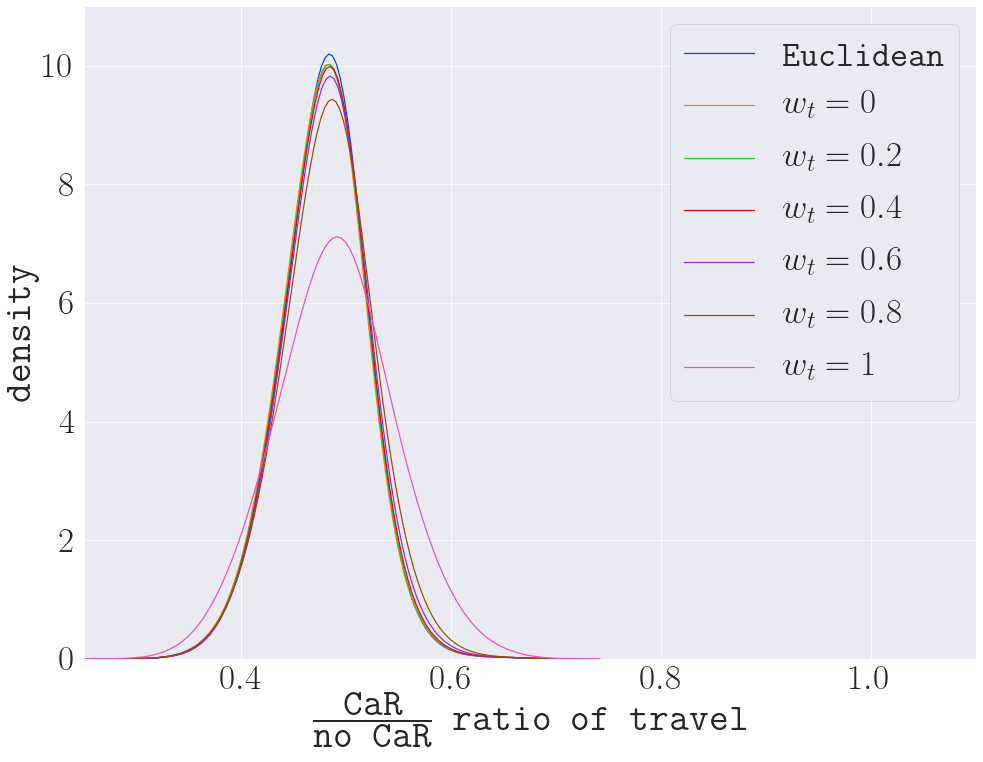

In [117]:
plt.figure(figsize=(16,12))
EUCL_mdict, EUCL_matchDF = get_distance_measurements(ridersDF, ridesDF, best_EUCL_matches_per_ride)
sns.distplot(EUCL_mdict['ratio_of_travel'],hist=False,kde=True,kde_kws={'bw' : 0.02},label='Euclidean')
for i,best_matches_per_ride in enumerate(best_matches):
    if i % 2 == 1:
        continue
    mdict, matchDF = get_distance_measurements(ridersDF,ridesDF,best_matches_per_ride)
    sns.distplot(mdict['ratio_of_travel'],hist=False,kde=True,kde_kws={'bw' : 0.02},label=r'$w_t = {}$'.format(w_t_list[i]))
plt.xlabel(r'$\frac{\texttt{CaR}}{\texttt{no CaR}}$ ratio of travel')
plt.ylabel('density')
plt.ylim((0,11))
plt.xlim((0.25,1.1))
plt.legend()


In [108]:
mdict, matchDF = get_distance_measurements(ridersDF,ridesDF,best_matches[5])

In [111]:
mdict['ratio_of_travel'].describe()

count    12731.000000
mean         0.480052
std          0.037414
min          0.331113
25%          0.457319
50%          0.481869
75%          0.503628
max          0.663114
dtype: float64

In [63]:
best_EUCL_matches_per_ride

{'1179462': trip_id
 1454447                0.857931
 24491335#2_1.030377    0.842157
 24491335#2_3.027190    0.842121
 24491335#2_1.028115    0.842115
 dtype: float64, '152567': trip_id
 1172601    0.857490
 1026474    0.856955
 477928     0.855105
 244177     0.852474
 dtype: float64, '1289340': trip_id
 1312299    0.966853
 1380282    0.950256
 1126177    0.948783
 353766     0.936399
 dtype: float64, '329072': None, '1009349': None, '1398707': trip_id
 1427012    0.880020
 125894     0.879992
 1207618    0.877171
 1086152    0.874735
 dtype: float64, '1587125': trip_id
 1133895    0.959490
 1140346    0.955160
 1027672    0.949238
 1177891    0.944350
 dtype: float64, '1195414': trip_id
 199909     0.898881
 108679     0.881864
 1046257    0.873779
 1114581    0.873495
 dtype: float64, '1360865': trip_id
 1527397    0.884293
 418781     0.853463
 1015498    0.843247
 1477340    0.839254
 dtype: float64, '1419557': trip_id
 1056413    0.894614
 1367801    0.877434
 112070     0.8647

### Now let's measure performance

First things first, let's see how many got at least 4 candidates to get a match from:

In [29]:
count = 0
for k,v in best_matches_per_ride.items():
    if v is not None:
        count += 1
print(count,len(best_matches_per_ride),count/len(best_matches_per_ride))

9930 20000 0.4965


Next let's see how much travel is added for OO and DD

#### The important measure is how much they go out of their way comparing to the part where they carpool

In [48]:
def get_distance_measurements(ridersDF, ridesDF, best_matches_per_ride):
    ridersDF = ridersDF.copy()
    ridersDF['best match id'] = ridersDF.apply(lambda row: best_matches_per_ride[row.name].index.values[0] if best_matches_per_ride[row.name] is not None else None, axis = 1)
    matchDF = ridersDF.merge(ridesDF,left_on='best match id', right_index=True, suffixes=[' rider', ' match'])
    OO_travels = np.sqrt(np.square( (matchDF['orig x rider'] - matchDF['orig x match'])* 20 )
                   + np.square( (matchDF['orig y rider'] - matchDF['orig y match'])* 20 ) )
    OO_times = matchDF['orig time match'] - matchDF['orig time rider']
    DD_travels = np.sqrt(np.square( (matchDF['dest x rider'] - matchDF['dest x match'])* 20 )
                   + np.square( (matchDF['dest y rider'] - matchDF['dest y match'])* 20 ) )
    DD_times = matchDF['dest time rider'] - matchDF['dest time match']
    ratio_of_total_cp_travel_to_noncp_for_those_with_a_match = (matchDF['displacement(km) match'])/(matchDF['displacement(km) match']+matchDF['displacement(km) rider'])
    ret = {}
    ret['OO_travels'] = OO_travels
    ret['OO_times'] = OO_times
    ret['DD_travels'] = DD_travels
    ret['DD_times'] = DD_times
    ret['ratio_of_travel'] = ratio_of_total_cp_travel_to_noncp_for_those_with_a_match
    
    return ret, matchDF

In [51]:
measurements_dict, matchDF = get_distance_measurements(ridersDF,ridesDF,best_matches_per_ride)

In [52]:
EUCL_measurements_dict, EUCL_matchDF = get_distance_measurements(ridersDF, ridesDF, best_EUCL_matches_per_ride)

In [37]:
# xyt_columns = ['orig time','orig x','orig y','dest time','dest x','dest y']

In [53]:
measurements_dict['ratio_of_travel'].describe()

count    9930.000000
mean        0.482960
std         0.032884
min         0.360677
25%         0.461730
50%         0.484029
75%         0.503916
max         0.617629
dtype: float64

In [54]:
EUCL_measurements_dict['ratio_of_travel'].describe()

count    9930.000000
mean        0.481901
std         0.032096
min         0.360677
25%         0.461747
50%         0.483551
75%         0.502685
max         0.617629
dtype: float64

Text(0, 0.5, 'frequency')

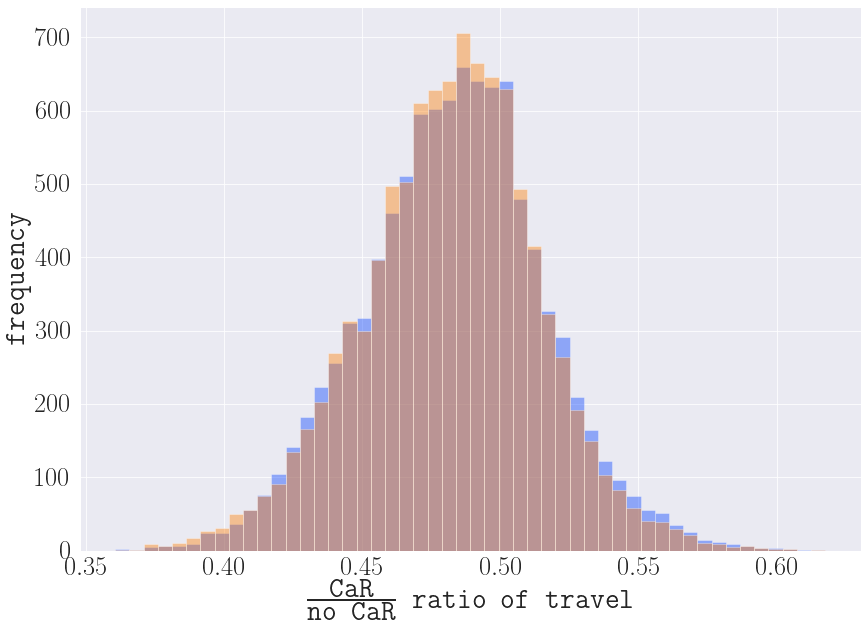

In [55]:
plt.figure(figsize=(14,10))
sns.distplot(measurements_dict['ratio_of_travel'],norm_hist=False,kde=False,kde_kws={'bw' : 0.02})
sns.distplot(EUCL_measurements_dict['ratio_of_travel'],norm_hist=False,kde=False,kde_kws={'bw' : 0.02})
plt.xlabel(r'$\frac{\texttt{CaR}}{\texttt{no CaR}}$ ratio of travel')
plt.ylabel('frequency')

In [ ]:
plt.figure(figsize=(14,10))
sns.distplot(measurements_dict['ratio_of_cp_to_noncp'],norm_hist=False,kde=False,kde_kws={'bw' : 0.02})
plt.xlabel(r'$\frac{\texttt{CaR}}{\texttt{no CaR}}$ ratio of travel')
plt.ylabel('frequency')

In [116]:
mpl.rc('text', usetex=True)
mpl.rcParams['font.monospace'] = ['Computer Modern Typewriter','DejaVu Sans Mono','Bitstream Vera Sans Mono','Courier']
sns.set(style = 'darkgrid', context = 'paper', font_scale=4)
sns.set_palette("bright")
mpl.rcParams['font.family'] = ['monospace']